# Flemming-Viot Simulations 
Itamar Fiorino

In [1]:
include("CTMC_methods.jl");
using LinearAlgebra
using Distributions
using Plots

rng = MersenneTwister(9090);

**Flemming Viot Scheme**

Simulation procedure:
- Initialize particles with random start states
- Initialize buffer
- Generate exponential variable (high precision) and select particle to be moved (buffer)
- Move particle, resampling if escaped
- Update buffer
  
Soft killing uses sum of exponentials (i.e. soft killing as a "state"). Inherits methods from CTMC_methods.jl

## Initialize particles

In [2]:
Q = birth_death(10, 10, 20)
Q̂ = transpose(Q_hat(Q, [1,10]));
# display(Q̂)
# println(eigvals(Q̂))
# println(eigvals(transpose(Q̂)))
# println(eigvecs(Q̂)[:,10])

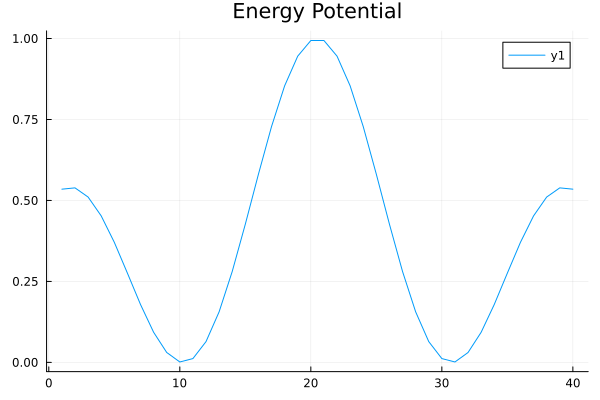

In [3]:
function distribution_from_occupation(occupation::Vector{<:Real})::Vector{Float64}
    p = 1/sum(occupation)
    return map(x -> p*x, occupation)
end

function soft_rand(p::Vector{Float64}, absorbing)
    r = rand()
    for i in setdiff(1:length(p), absorbing)
        r -= p[i]
        if r <= 0
            return i
        end
    end
    return i
end

function initialize(n, Q, absorbing, initial_distribution)::Tuple{Vector{UInt32}, Vector{Float64}}
    # Pre-allocate response using sizehint!
    n_states = size(Q)[1]
    # res = n ≤ 65535 ? Vector{UInt16} : Vector{UInt32}
    particles = Vector{UInt32}(rand(Multinomial(n, initial_distribution)))
    sizehint!(particles, n_states)
    weighted_particles = Vector{Float64}([(-Q[i, i] * particles[i]) for i in 1:n_states])
    return particles, weighted_particles
end

function evolve!(particles, weighted_particles, Q, absorbing, verbose = false)::Bool
    initial_distribution = distribution_from_occupation(weighted_particles)
    from = soft_rand(initial_distribution, absorbing)
    r = rand()
    to = state(from, Q, r)
    killed = false
    if to in absorbing
        to = soft_rand(distribution_from_occupation(particles), absorbing)
        killed = true
    end
    if verbose
        @printf "Particle %i moved to %i\n" from to
    end
    particles[from] -= 1
    particles[to] += 1
    weighted_particles[from] -= -Q[from, from]
    weighted_particles[to] += -Q[to, to]
    return killed
end

function scale!(particles, weighted_particles, k::Int)
    particles = [i * k  for i in particles]
    particles = [i * k  for i in particles]
end

### Transition Parameters
const n_states = 40
const start_n_particles = 400
# λ = 1
# μ = 1
# Q = birth_death(n_states, μ, λ)
function f(x)
    return - 4 * x * (x-1)
end
function g(x)
    return 1 - sin(2 * π * x)^2
end
function J(x)
    return g(x/(n_states + 1)) * (.5 + .5 * f(x / (n_states+1)))
end
J_vect = map(J, 1:n_states)
display(plot(1:n_states, J_vect, title="Energy Potential"))
# display(plot(1:n_states, map(x -> exp(-x), J_vect), title="Energy Potential"))
Q = rates_energy_potential(J_vect)
absorbing = [1, n_states]

initial_distribution = distribution_from_occupation([(i in absorbing ? 0 : 1) for i in 1:n_states])
particles, weighted_particles = initialize(start_n_particles, Q, absorbing, initial_distribution);

## Computing Perron-Frobenius Eigenvalues
The below code finds the stationary distribution for the original chain, and notices differences in the computed eigenvalues of $Q$ and $Q^T$.

Perron-Frobenius eigenvalues computed are: 3.024170983084718e-16 and -1.4960489792554516e-16
L¹: 1.0
L² residual: 3.813550073987298e-16


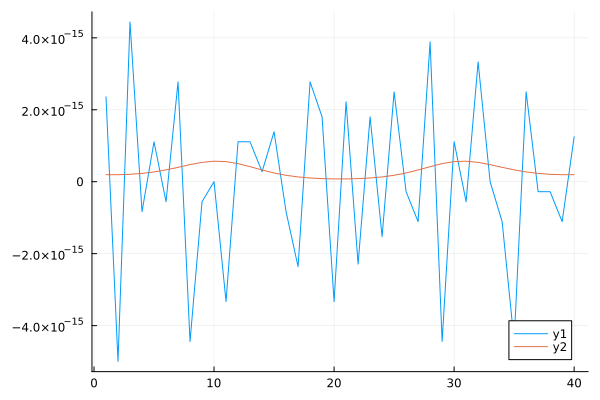

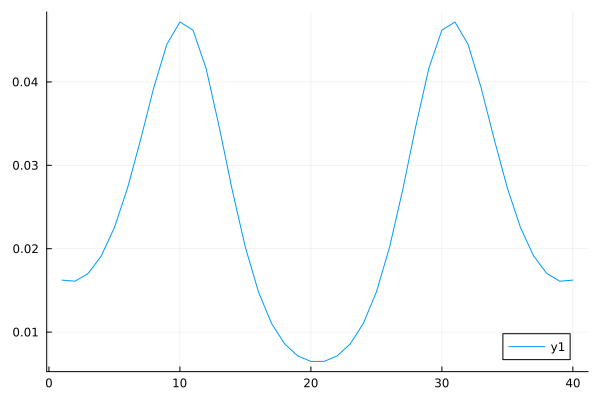

In [4]:
# println(Q)
function diff(Q, v, λ)
    h = zeros(length(v))
    mul!(h, Q, v)
    return norm(h - λ * v)
end
Qᵗ = transpose(Q)
vals = eigvals(Qᵗ)
valst = eigvals(Q)
vecs = eigvecs(Qᵗ)
println("Perron-Frobenius eigenvalues computed are: ", maximum(vals), " and ", maximum(valst))
pf_eig, pf_index = findmax(vals)
vec = vecs[: , pf_index]
vec = vec ./ norm(vec, 1)
println("L¹: ", norm(vec, 1))
println("L² residual: ", diff(Qᵗ, vec, pf_eig))
# display(plot(vec.*n_states))
h = zeros(length(vec))
mul!(h, Qᵗ, vec)
p = plot(h.*n_states)
plot!(p, vec .* n_states .* pf_eig)
display(p)
display(plot(vec))

Scaling on iteration 10000
Scaling on iteration 20000
Scaling on iteration 30000
Scaling on iteration 50000
Scaling on iteration 80000
Scaling on iteration 120000
 12.398811 seconds (10.04 M allocations: 789.705 MiB, 0.51% gc time, 3.94% compilation time: 4% of which was recompilation)


[ Info: Saved animation to /Users/azul/Documents/Numerics/QSD/flemming-viot.gif


Plots.AnimatedGif("/Users/azul/Documents/Numerics/QSD/flemming-viot.gif")
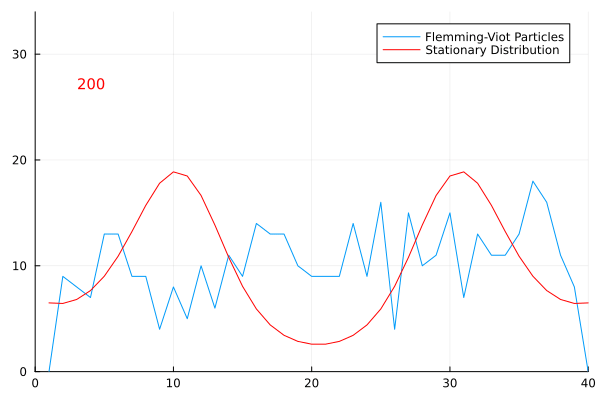

In [5]:
### Flemming-Viot Simluation
const n_iters = 160000
doubling_schedule = [10000, 20000, 30000, 50000, 80000, 120000]

a = Plots.Animation()
k = 2 * maximum(particles)
z = 0
@time for i in 1:n_iters   
    if i%200 == 0
        plt = plot(particles, ylim=(0, max(k, maximum(particles))), xlim=(0,n_states), lab="Flemming-Viot Particles")
        plot!(plt, vec.* start_n_particles * 2^z, color="red", lab = "Stationary Distribution")
        Plots.annotate!(5, max(.8k, .8maximum(particles)), text(string(i), :red, :right, 10)) 
        frame(a, plt)
    end
    if i in doubling_schedule
        println("Scaling on iteration ", i)
        particles = particles .* 2
        weighted_particles = weighted_particles .* 2
        # scale!(particles, weighted_particles, 2)
        k = k * 2
        z += 1
    end
    evolve!(particles, weighted_particles, Q, absorbing)
end

gif(a, "flemming-viot.gif")